In [ ]:
%matplotlib inline


적대적 예제 생성(Adversarial Example Generation)
====================================================

**저자:** `Nathan Inkawhich <https://github.com/inkawhich>`__
**번역:** `BONGMO KIM <https://github.com/bongmo>`__

이 글을 읽고 있다면, 여러분은 이미 머신러닝 모델이 얼마나 효과적인지 그 진가를 알고 있을 것입니다.
머신 러닝 연구는 ML(Machine Learning) 모델을 더욱 빠르고 정확하며 효율적이게 하는 방향으로 진행 되고 있습니다.
그러나 모델을 속이려하는 적에 대한 보안과 견고함은 모델을 설계하고 훈련할 때 종종 간과되는 부분입니다.

이 튜토리얼은 ML 모델들의 보안 취약점에 대한 인식을 높이고, 요즘 화두가 되고있는 적대적 머신 러닝에 대한 통찰력을 제공할 것입니다.
이미지에 눈치챌 수 없는 작은 변화(perturbation)를 추가하면 모델 성능이 크게 달라질 수 있다는 사실에 놀랄 수 있습니다.
이번 튜토리얼에서는 이미지 분류기의 예제를 통해 위 내용에 대해 살펴볼 것입니다.
특히 우리는 가장 많이 사용되는 공격 방법 중 하나인 FGSM (Fast Gradient Sign Attack)을 이용해 MNIST 분류기를 속여 볼 것입니다.



위협 모델
------------

상황에 따라 다양한 범주의 적대적 공격이 있는데 각각 목표가 다르고 공격자가 알고 있는 정보
대한 가정도 다릅니다. 그러나 보통 가장 중요한 목표는 입력 데이터에 최소한의 작은 변화를 
추가하여 이것이 의도적으로 잘못 분류되게 하는 것입니다. 공격자가 가지고 있는 정보에 대한 
가정에는 여러 종류가 있는데, 보통 **화이트박스** 와 **블랙박스** 두 가지가 있습니다. 
*화이트박스* 공격은 공격자가 모델에 대해 아키텍처, 입력, 출력, 가중치를 포함한 모든 것을
알고 있고 접근할 수 있다고 가정합니다. *블랙박스* 공격은 공격자가 모델의 입력과 출력에 
대해서만 접근 가능하고 모델의 가중치와 아키텍처에 관한 내용은 모른다고 가정합니다. 
공격자의 목표는 오분류 및 **소스/타겟 오분류** 를 포함하는 여러 유형이 있습니다. 
*오분류* 의 목표는 공격자가 출력으로 나온 분류 결과가 잘못 되도록 하나 새로운 분류 결과가
어떤 것이 나오는지 신경 쓰지 않는 것을 의미합니다. *소스/타겟 오분류* 는 공격자가 
원래 특정 소스 클래스의 이미지를 다른 특정 대상 클래스로 분류하도록 변경하려고 함을 의미합니다.


이 경우 FGSM 공격은 *오분류* 를 목표로 하는 화이트 박스 공격입니다. 
이런 배경 정보를 갖고 공격에 대해 자세히 알아 보겠습니다.

빠른 변화도 부호 공격
-------------------------

공격 방법에 있어 초기 방식이면서 가장 유명한 방식은 *빠른 변화도 부호 공격 (FGSM)* 이라고 하며 
`적대적 예제에 대한 설명과 활용 <https://arxiv.org/abs/1412.6572>`__ 에서 
이안 갓펠로우가 기고하였습니다.
이 공격법은 놀랍도록 강력하지만 직관적입니다. 학습 방식, *변화도(gradients)* 를 활용하여 신경망을 공격하도록 
설계 되었습니다. 아이디어는 간단합니다. 역전파 변화도를 기반으로 가중치를 조정하여 손실을 최소화하기보다는
공격이 동일한 역전파 변화도를 기반으로 *손실을 최대화하하는 방향으로 입력 데이터를 조정* 합니다. 
다시 말해 공격은 입력 데이터에서 계산된 손실 변화도를 사용하고 입력 데이터를 조정하여 손실이 최대가 되게 합니다.



In [1]:
# 
# 코드로 넘어가기 전에 유명한 `FGSM <https://arxiv.org/abs/1412.6572>`__ 판다 예제를 
# 보고 몇 가지 표기법을 정리하겠습니다.
#
# .. 그림:: /_static/img/fgsm_panda_image.png
#    :alt: fgsm_panda_image
#
# 그림으로부터, :math:`\mathbf{x}` 는 원본 입력 이미지가 "판다" 로 올바르게 분류된 것을 의미하고,
# :math:`y` 는 :math:`\mathbf{x}` 를 위한 정답 라벨이며, :math:`\mathbf{\theta}` 는 모델의
# 파라미터를, :math:`J(\mathbf{\theta}, \mathbf{x}, y)` 는 네트워크의 학습을 위해서 사용되는 손실을 나타냅니다.
# 공격은 :math:`\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)` 계산을 위해 입력 데이터에 변화도를 역전파합니다.
# 그러고 나서, 변화도는 손실 값이 최대화되는 방향으로 (예를 들면, :math:`sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))` ) 
# 작은 스텝(step) 만큼 (그림에서는 :math:`\epsilon` 혹은 :math:`0.007`) 입력 데이터에 적용됩니다.
# 결과로 나오는 작은 변화된 이미지( :math:`x'` )는 타겟 네트워크에 의해 "긴팔원숭이"로 *오분류* 되나 여전히 육안으로는
# 분명히 "판다" 입니다.
# 
# 이제 본 튜토리얼의 동기가 명확해지길 바라며, 구현으로 넘어가 보겠습니다.
# 

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

구현
--------------

이 섹션에서는 튜토리얼의 입력 매개 변수에 대해 설명하고 공격중인 모델을
정의한 다음 공격을 코딩하고 일부 테스트를 실행합니다.

입력
~~~~~~

이 학습서에는 입력이 3 개이며 다음과 같이 정의됩니다:

- **epsilons** - 실행에 사용할 엡실론의 리스트입니다. 엡실론 0의 값은 원래 테스트 셋의 모델 성능을
  나타내므로 목록에 유지하는 것이 중요합니다. 또한 직관적으로 엡실론이 클수록 작은 변화가 더 눈에 띄지만
  모델 정확도를 저하 시키는 측면에서 더 효과가 있습니다. 여기서 데이터의 범위는 0-1 이기 때문에 
  엡실론의 값은 1을 초과할 수 없습니다.

- **pretrained_model** - `pytorch/examples/mnist <https://github.com/pytorch/examples/tree/master/mnist>`__ 
   를 통해 미리 학습된 MNIST 모델의 경로. 
   튜토리얼을 간편하게 하려면 `여기 <https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing>`__ 에서 미리 학습된 모델을 다운로드하세요.

-  **use_cuda** - CUDA 를 사용할지 말지 정하는 이진 플래그. 
   본 튜토리얼에서는 CPU 시간이 오래 걸리지 않으므로 CUDA를 지원하는 GPU 의 여부는 중요하지 않습니다.




In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

공격을 받는 모델
~~~~~~~~~~~~~~~~~~

앞서 말한대로, 공격을 받는 모델은 `pytorch/examples/mnist <https://github.com/pytorch/examples/tree/master/mnist>`__
와 동일한 MNIST 모델입니다. 본인의 MNIST 모델을 학습 및 저장하는 방식으로 하거나 제공된 모델을 다운로드 해 사용하는 식으로 진행할 수 있습니다.
여기서 *Net* 정의 및 테스트 데이터 로더는 MNIST 예제에서 복사 하였습니다. 
이 섹션의 목적은 모델과 데이터 로더를 정의한 다음, 모델을 초기화하고 미리 학습된 가중치를 읽어오는 것입니다.




In [4]:
# LeNet 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST 테스트 데이터셋과 데이터로더 선언
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# 어떤 디바이스를 사용할지 정의
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 모델 초기화하기
model = Net().to(device)

# 미리 학습된 모델 읽어오기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 모델을 평가 모드로 설정하기. 드롭아웃 레이어들을 위해 사용됨
model.eval()

0it [00:00, ?it/s]Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ../data\MNIST\raw\train-images-idx3-ubyte.gz
 84%|████████▍ | 8372224/9912422 [00:03<00:00, 5108846.67it/s]Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]

0it [00:00, ?it/s]Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:10, 160960.42it/s]

  4%|▍         | 73728/1648877 [00:00<00:04, 318699.09it/s]

  8%|▊         | 139264/1648877 [00:00<00:03, 446273.23it/s]

 14%|█▍        | 237568/1648877 [00:00<00:02, 625763.47it/s]

 20%|██        | 335872/1648877 [00:01<00:01, 735949.13it/s]

 26%|██▌       | 425984/1648877 [00:01<00:01, 770896.18it/s]

 41%|████      | 671744/1648877 [00:01<00:00, 1288110.36it/s]

 59%|█████▊    | 966656/1648877 [00:01<00:00, 1793578.42it/s]

 89%|████████▉ | 14745

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

FGSM 공격
~~~~~~~~~~~

이제 원래 입력을 교란시켜 적대적인 예를 만드는 함수를 정의 할 수 있습니다. 
``fgsm_attack`` 함수는 입력 파라미터로 3가지를 가집니다. 첫번째는 원본 *이미지* ( $x$ ), 
두번째는 *엡실론* 으로 픽셀 단위의 작은 변화를 주는 값입니다 ( $\epsilon$ ). 
마지막은 *data_grad* 로 입력 영상 ( $\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$ ) 에 대한 변화도 손실 값입니다. 
아래 식에 따른 작은 변화가 적용된 이미지를 생성합니다.

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

마지막으로 데이터의 원래 범위를 유지하기 위해, 작은 변화가 적용된 이미지가 $[0,1]$ 범위로 잘립니다.




In [5]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad 의 요소별 부호 값을 얻어옵니다
    sign_data_grad = data_grad.sign()
    # 입력 이미지의 각 픽셀에 sign_data_grad 를 적용해 작은 변화가 적용된 이미지를 생성합니다
    perturbed_image = image + epsilon*sign_data_grad
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)를 추가합니다
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 작은 변화가 적용된 이미지를 리턴합니다
    return perturbed_image

테스팅 함수
~~~~~~~~~~~~~~~~

마지막으로 본 튜토리얼의 핵심 결과는 ``테스트`` 함수에서 오게 됩니다. 
이 테스트 기능을 호출 할 때마다 MNIST 테스트 셋에서 전체 테스트 단계를 수행하고 최종 정확도를 보고합니다.
그러나 이 함수에는 *엡실론* 입력도 필요합니다. 이는 ``테스트``` 함수가 $\epsilon$ 크기에 따라 공격자의 공격을 받는 모델의 
정확도을 보고하기 때문입니다. 더 구체적으로 보면 테스트 셋의 각각의 샘플에서 테스트 함수는 입력 데이터에 대한 손실 변화도( $data\_grad$ )를 계산하고, 
 ``FGSM 공격``( $perturbed\_data$ )을 받은 작은 변화가 적용된 이미지를 만들고 나서 작은 변화가 적용된 이미지가 적대적인지 확인을 합니다. 
추가로 모델의 정확도를 테스트하기 위해서 테스트 함수는 나중에 시각화하여 볼 수 있도록 성공적으로 얻은 적대적 이미지를 저장하고 반환합니다.




In [6]:
def test( model, device, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in test_loader:

        # 디바이스(CPU or GPU) 에 데이터와 라벨 값을 보냅니다
        data, target = data.to(device), target.to(device)

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        data_grad = data.grad.data

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            # 0 엡실론 예제에 대해서 저장합니다
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples

공격 실행
~~~~~~~~~~

구현의 마지막 부분은 공격을 실행하는 것입니다. 여기서 전체 테스트 스텝을 각 *엡실론* 값에 실행합니다. 
각 엡실론마다 최종 정확도와 성공적인 일부 적대 사례를 저장하여 다음 섹션에 표시합니다. 
엡실론 값이 증가함에 따라 출력된 정확도가 어떻게 감소하는지 보십시오. 
또한, $\epsilon=0$ 인 경우에는 공격이 없는 원본 테스트 정확도임을 보입니다.




In [7]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


결과
-------

정확도 vs 엡실론
~~~~~~~~~~~~~~~~~~~

첫 번째 결과는 정확도 vs 엡실론 을 도식화 한 것 입니다. 
앞에서 언급했듯이, 엡실론이 증가함에 따라 우리는 테스트 정확도가 감소할 것으로 예상합니다.
이는 학습을 더 진행해 갈수록 엡실론이 클수록 손실을 극대화 할 방향으로 진행되기 때문입니다.
엡실론 값이 선형적으로 분포하더라도 곡선의 추세는 선형의 형태가 아닙니다.
예를 들면, math:`\epsilon=0.05` 에서의 정확도가 $\epsilon=0$ 보다 약 4% 낮지만
$\epsilon=0.2$ 에서의 정확도는 $\epsilon=0.15$ 보다 약 25% 정도 낮습니다.
또한, $\epsilon=0.25$ 와 $\epsilon=0.3$ 사이의 모델 정확도는 랜덤으로
10개중 1개를 선택했을 때의 정확도와 유사한 수준입니다.



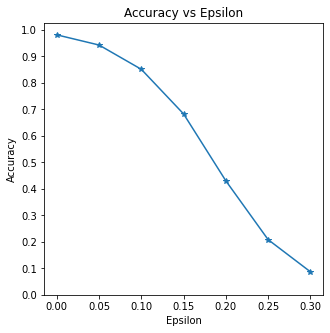

In [8]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

샘플 적대적 예제들
~~~~~~~~~~~~~~~~~~~~~~~~~~~

공짜 점심은 없다는 것을 기억하시나요? 이 경우에는 엡실론이 증가할수록 테스트 정확도는 떨어집니다. 
**그러나** 작은 변화는 더 쉽게 인식할 수 있게 됩니다.
실제로 정확도 저하와 공격자가 고려해야 하는 이해도 사이에는 상충 관계(tradeoff)가 있습니다.
여기서 우리는 각 엡실론 값에서 성공적인 대적 사례를 보이는 몇 가지 예를 보겠습니다.
아래 이미지의 첫번째로 열은 $\epsilon=0$ 인 예제들로 작은 변화가 없는 원본의 "깨끗한" 이미지들을 나타냅니다.
각 이미지의 위의 글자는 "원래 분류 결과 -> 적대적 분류 결과"를 나타냅니다.
$\epsilon=0.15$ 에서 작은 변화가 눈에 띄기 시작하고 $\epsilon=0.3$ 에서는 확실해 보입니다.
그러나 모든 경우에 대해서 노이즈가 추가되었더라도 사람은 올바르게 분류를 수행할 수 있습니다.



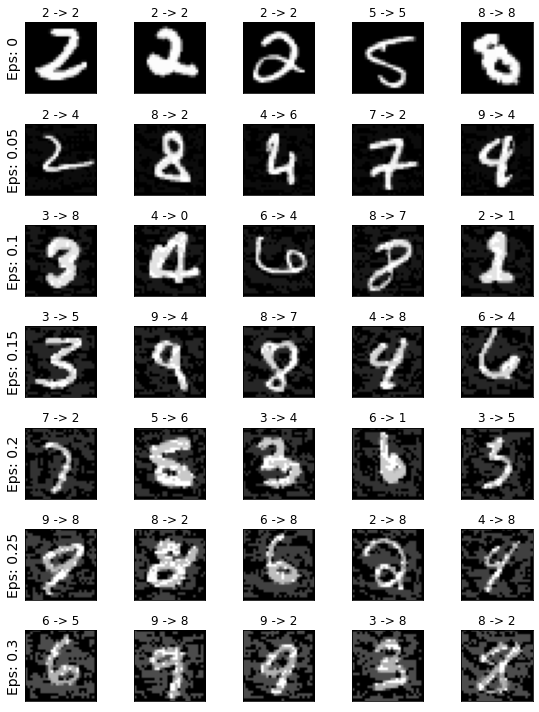

In [9]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

다음 단계는?
-----------------

이번 튜토리얼에서 적대적 머신 러닝에 대한 통찰을 얻을 수 있었기를 바랍니다.
튜토리얼의 내용으로부터 앞으로 더 많은 것들을 알아나갈 수 있습니다.
튜토리얼의 적대적 공격 예제는 본 분야의 초급 단계이며 
적대적 상황으로부터 ML 모델을 공격하고 방어하는 방법에 대한 많은 후속 아이디어가 있습니다.
사실 NIPS 2017 에서 적대적 공격과 방어에 대한 경쟁(competition)이 있었고 여기서 사용된
다양한 방법들은 다음 논문에 정리 되어 있습니다: `적대적 공격과 방어 경쟁 <https://arxiv.org/pdf/1804.00097.pdf>`__.
방어에 대한 연구는 자연스럽게 교란 및 해킹 목적으로 제작된 입력에 대해 머신 러닝 모델을
보다 *견고하게(robust)* 만드는 아이디어로 이어집니다.

또 다른 방향은 다른 도메인에서의 적의 공격과 방어입니다. 적대적 연구는 이미지 도메인에 제한되어 있지 않습니다. 
`여기 <https://arxiv.org/pdf/1801.01944.pdf>`__ 에서 음성-텍스트 변환 모델에서의 공격도 확인할 수 있습니다.
그러나 적대적 머신 러닝 분야에 대해서 많은 것을 알기 위한 최고의 방법은 많이 시도해보는 것입니다.
NIPS 2017 경쟁에서 소개된 다양한 공격 방법을 직접 구현해 보고, FGSM 과 어떤 점이 다른지 연구해 보세요.
그리고 나서 직접 만든 공격으로부터 모델을 방어해 보세요.


